
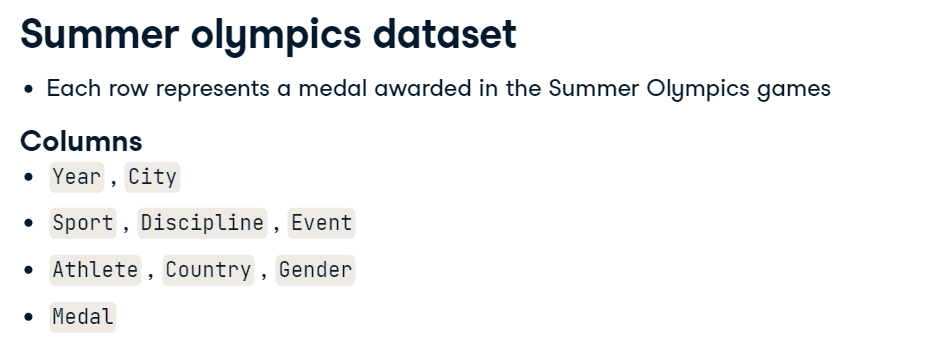
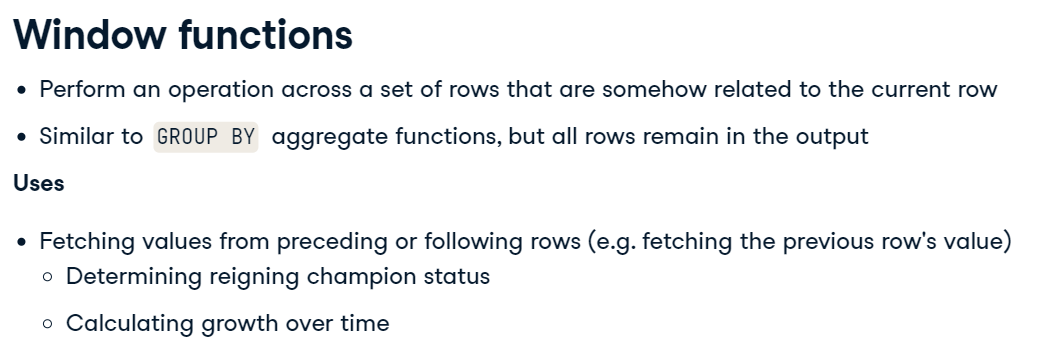
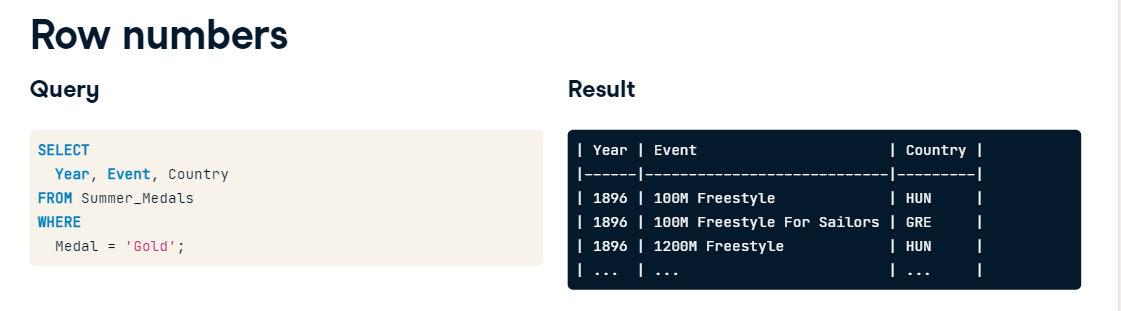
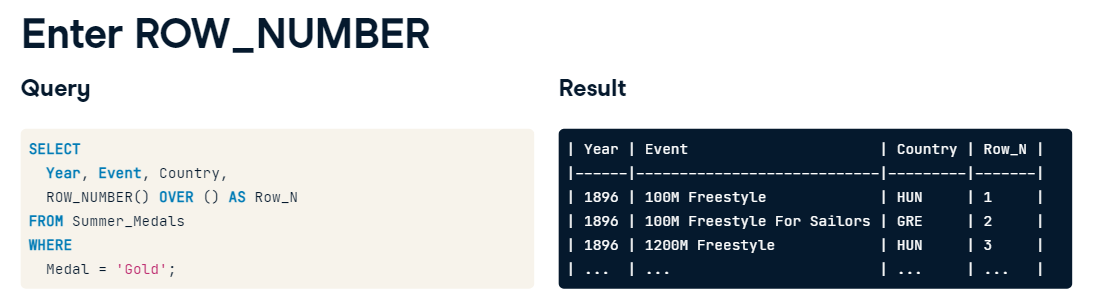
 - GROUP BY functions summarize data, whereas window functions don't affect the number of rows in the output.
- Window functions can fetch values from various parts of the table into a row. 


#### Numbering rows
The simplest application for window functions is numbering rows. Numbering rows allows you to easily fetch the nth row. For example, it would be very difficult to get the 35th row in any given table if you didn't have a column with each row's number.

```sql
SELECT
  *,
  -- Assign numbers to each row
  ROW_NUMBER() OVER() AS Row_N
FROM Summer_Medals
ORDER BY Row_N ASC;
```
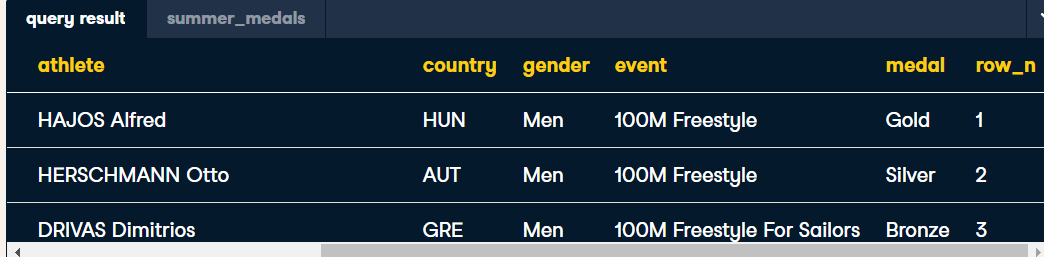


#### Numbering Olympic games in ascending order
The Summer Olympics dataset contains the results of the games between 1896 and 2012. The first Summer Olympics were held in 1896, the second in 1900, and so on. What if you want to easily query the table to see in which year the 13th Summer Olympics were held? You'd need to number the rows for that.


- Assign a number to each year in which Summer Olympic games were held.

```sql
SELECT
  Year,

  -- Assign numbers to each year
  ROW_NUMBER() OVER() AS Row_N
FROM (
  SELECT DISTINCT year
  FROM Summer_Medals
  ORDER BY Year ASC
) AS Years
ORDER BY Year ASC;
```

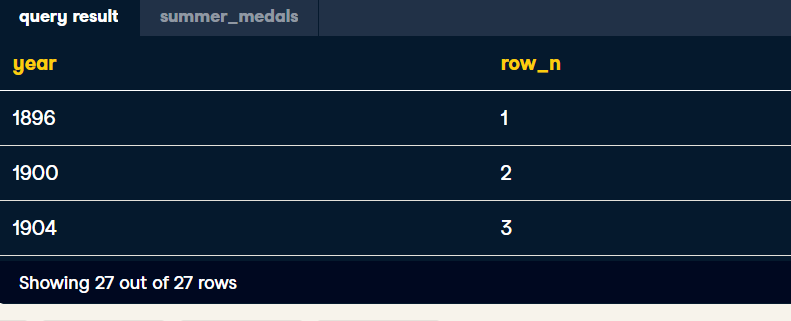

**ORDER BY** is a subclause of OVER. It orders the rows related to the current row that the window function will use. Taking the row numbering query, if you order by year in descending order within the OVER clause, the function will assign 1 to the first row in that window. That row will have the most recent year in the dataset.

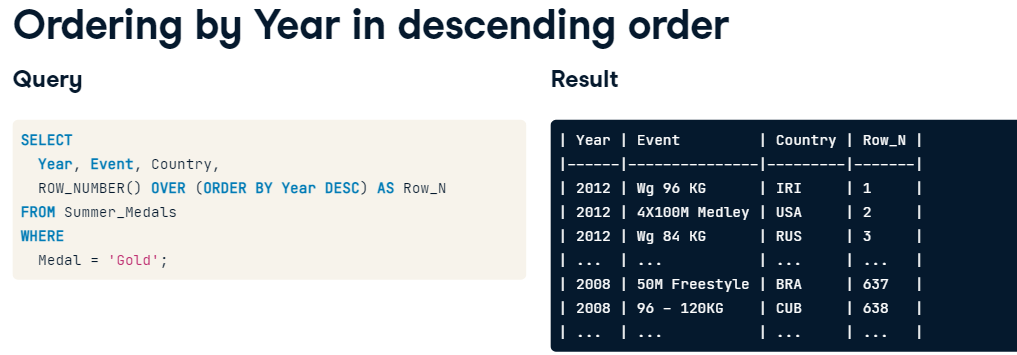


Adding ORDER BY within OVER changed the basis on which the function assigned numbers to rows, assigning lower numbers to the more recent rows.

In the previous results, notice that the results and numbers are only based on a sort by year. What if you want to sort by year and by event? You can order by multiple columns in the OVER clause, just like you normally can outside of it. That'll also change the numbers assigned to each row, since their positions have changed.

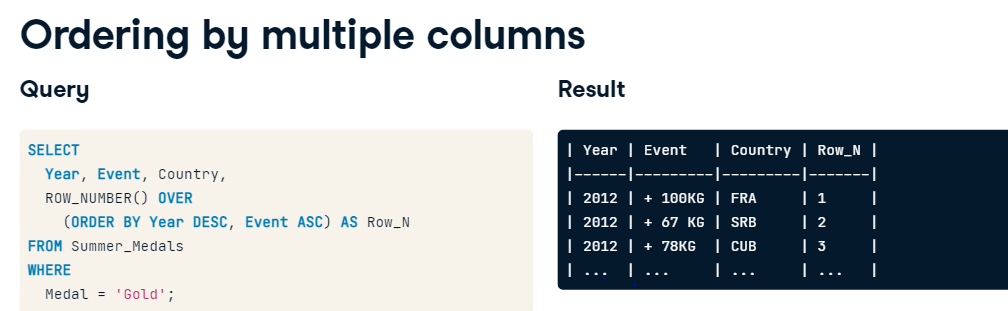

You can ORDER both inside and outside OVER at the same time. In this query, row numbers are assigned based on the year and the event, but the ordering outside OVER orders by country and row. How will these two orders be executed? First, ROW_NUMBER will assign numbers based on the order within OVER. So the row numbers are given after sorting the table by year and event. After that, the ORDER outside of OVER takes over, and sorts the results of the table by Country and row number. 

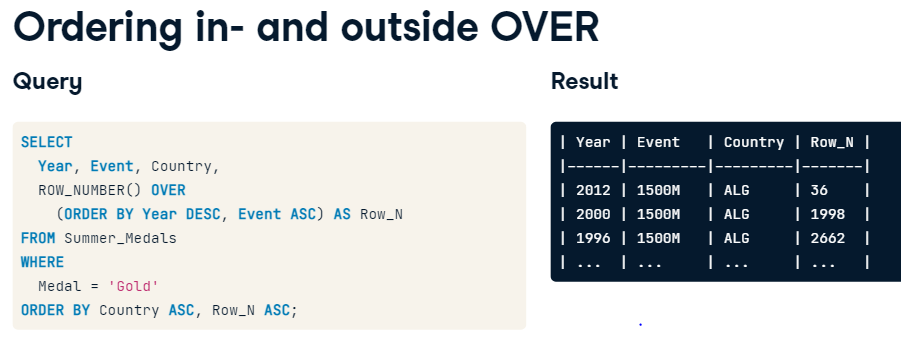

Notice that the first row in the result isn't the row with number 1, because the two orders are based on different columns. From that, you can conclude that the ORDER inside OVER takes effect before the ORDER outside of it.

One of the applications of window functions is determining reigning champion status. A reigning champion is a champion who's won both the previous and current years' competitions. To determine if a champion is a reigning champion, the previous and the current years' champions need to be in the same row, in two different columns, so that they can be compared. How can you get a previous row's value without complex self-joins? 

The answer is LAG. 

**LAG** is a window function that takes a column and a number n and returns the column's value n rows before the current row. Passing 1 as n returns the previous row's value.

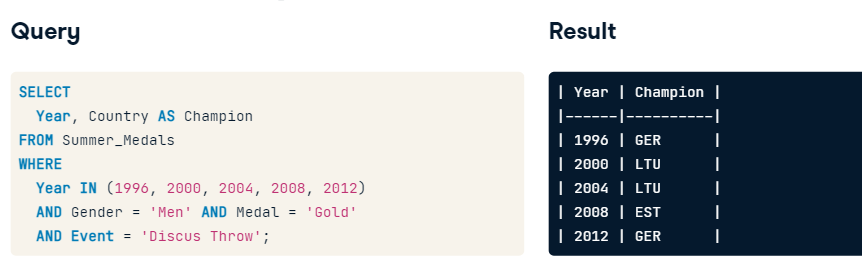

This query returns the Discus Throw champions.


Getting each year's champion is the first step to using LAG to get each year's previous champion.

After wrapping the previous query in a CTE, which is a way to temporarily store a query's results as a table, select the year and champion, and use LAG on the Champion column with an n of 1, ordering by year in ascending order in OVER. In the results, notice that Last_Champion contains Champion's value from the previous row. The first row has no previous row, so its value is null.

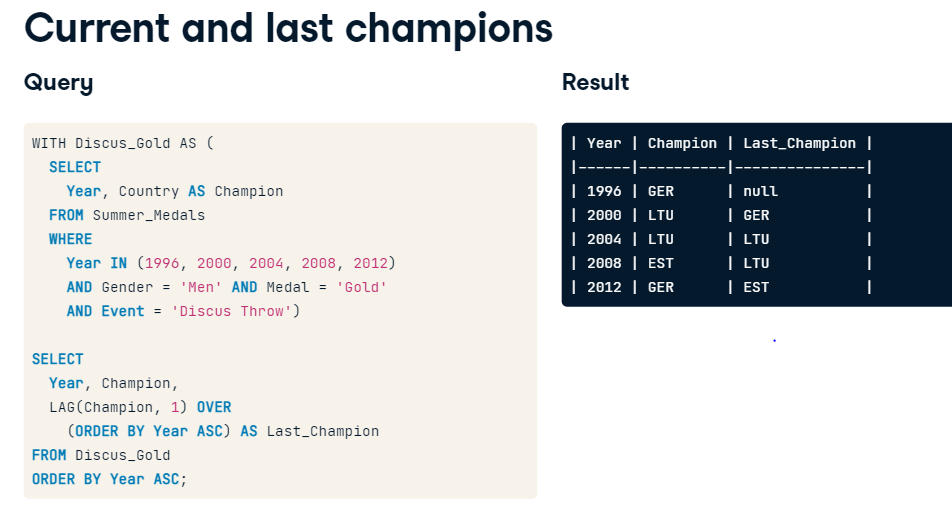


#### Numbering Olympic games in descending order
You've already numbered the rows in the Summer Medals dataset. What if you need to reverse the row numbers so that the most recent Olympic games' rows have a lower number?

- Assign a number to each year in which Summer Olympic games were held so that rows with the most recent years have lower row numbers.


```sql
SELECT
  Year,
  -- Assign the lowest numbers to the most recent years
  ROW_NUMBER() OVER (ORDER BY Year DESC) AS Row_N
FROM (
  SELECT DISTINCT Year
  FROM Summer_Medals
) AS Years
ORDER BY Year;
```
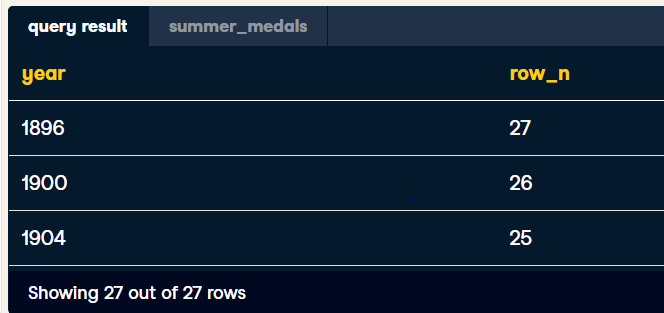


#### Numbering Olympic athletes by medals earned
Row numbering can also be used for ranking. For example, numbering rows and ordering by the count of medals each athlete earned in the OVER clause will assign 1 to the highest-earning medalist, 2 to the second highest-earning medalist, and so on.


- For each athlete, count the number of medals he or she has earned.
```sql
SELECT
  -- Count the number of medals each athlete has earned
  athlete,
  COUNT(medal) AS Medals
FROM Summer_Medals
GROUP BY Athlete
ORDER BY Medals DESC;
```

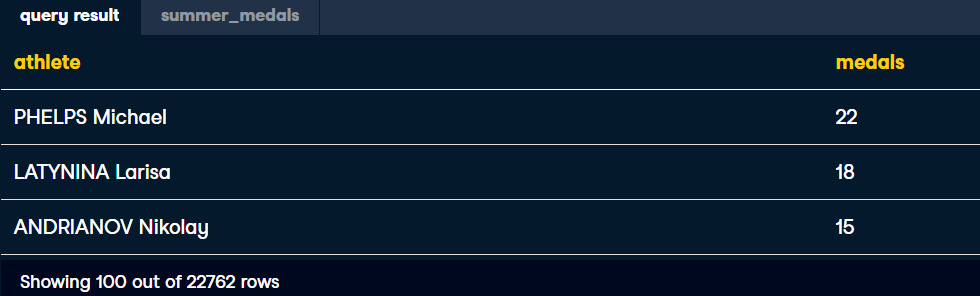


#### Numbering Olympic athletes by medals earned
Row numbering can also be used for ranking. For example, numbering rows and ordering by the count of medals each athlete earned in the OVER clause will assign 1 to the highest-earning medalist, 2 to the second highest-earning medalist, and so on.


- Having wrapped the previous query in the Athlete_Medals CTE, rank each athlete by the number of medals they've earned.

```sql
WITH Athlete_Medals AS (
  SELECT
    -- Count the number of medals each athlete has earned
    Athlete,
    COUNT(*) AS Medals
  FROM Summer_Medals
  GROUP BY Athlete)

SELECT
  -- Number each athlete by how many medals they've earned
  athlete,
  ROW_NUMBER() OVER (ORDER BY Medals DESC) AS Row_N
FROM Athlete_Medals
ORDER BY Medals DESC;
```

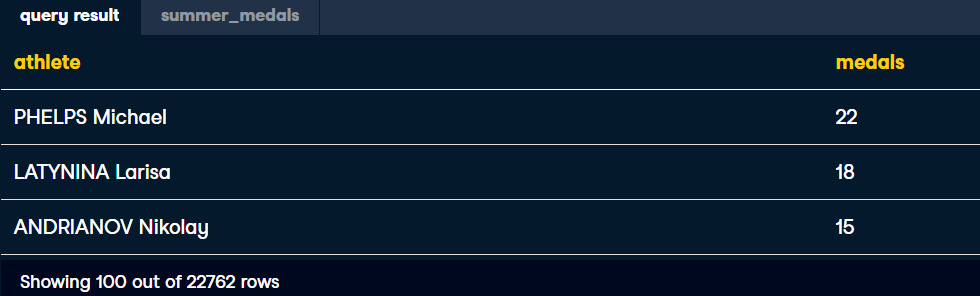


#### Reigning weightlifting champions
A reigning champion is a champion who's won both the previous and current years' competitions. To determine if a champion is reigning, the previous and current years' results need to be in the same row, in two different columns.


- Return each year's gold medalists in the Men's 69KG weightlifting competition.


```sql
SELECT
  -- Return each year's champions' countries
  year,
  country AS champion
FROM Summer_Medals
WHERE
  Discipline = 'Weightlifting' AND
  Event = '69KG' AND
  Gender = 'Men' AND
  Medal = 'Gold';
```
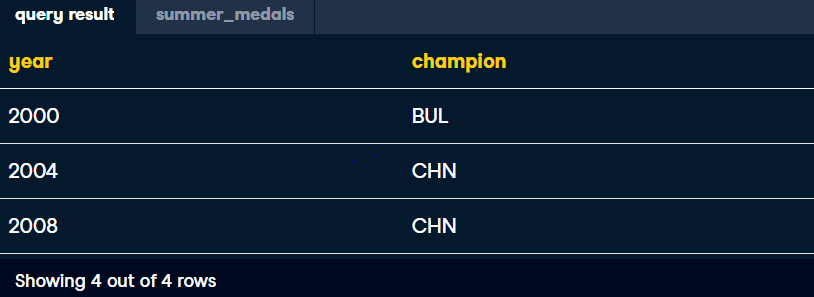

- Having wrapped the previous query in the Weightlifting_Gold CTE, get the previous year's champion for each year.

```sql
WITH Weightlifting_Gold AS (
  SELECT
    -- Return each year's champions' countries
    Year,
    Country AS champion
  FROM Summer_Medals
  WHERE
    Discipline = 'Weightlifting' AND
    Event = '69KG' AND
    Gender = 'Men' AND
    Medal = 'Gold')

SELECT
  Year, Champion,
  -- Fetch the previous year's champion
  LAG(Champion) OVER
    (ORDER BY Year ASC) AS Last_Champion
FROM Weightlifting_Gold
ORDER BY Year ASC;
```

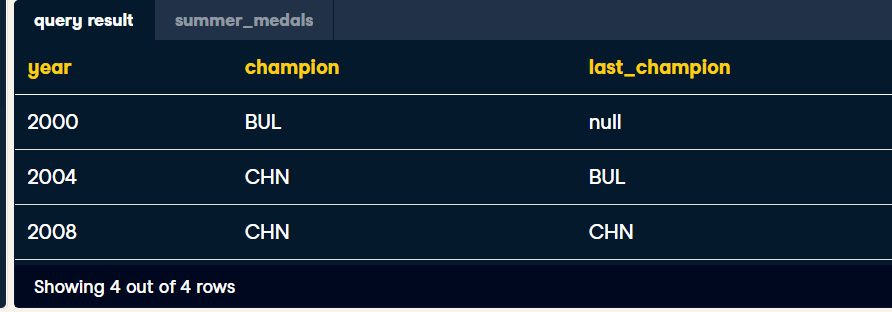


You now know how to change the behavior of a window function with the ORDER BY subclause. Another way to change its behavior is with the PARTITION BY subclause. 

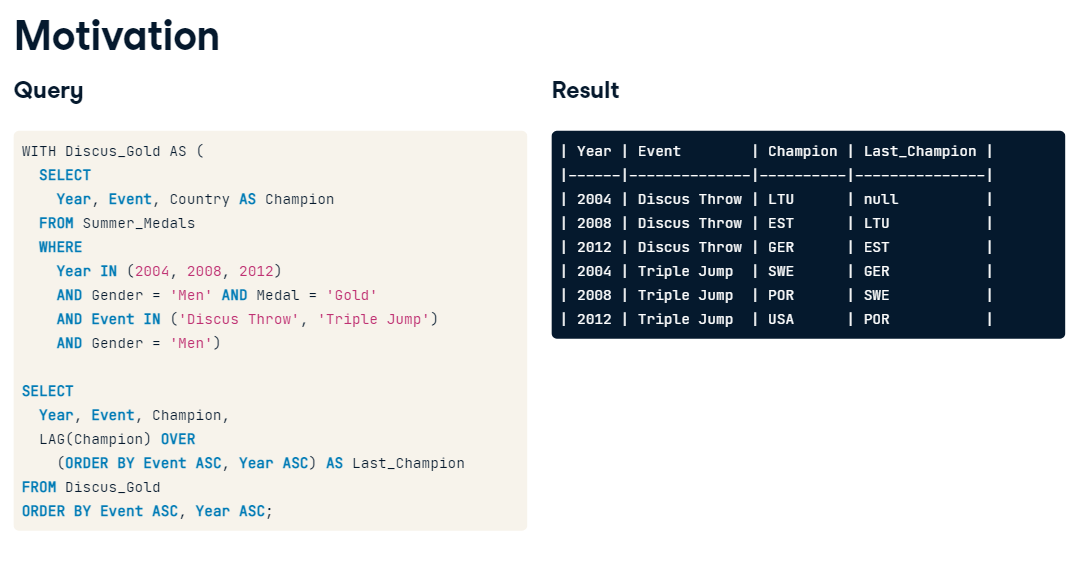

In addition to discus throw champions, this query includes triple jump champions as well. However, when using LAG, the first Triple Jump's Last_Champion is GER, Discus Throw's most recent champion, when in fact it should be null, since the two events are different and their champions are not related. How do you tell LAG to separate the two events?


##### PARTITION BY
This OVER subclause splits the table into partitions based on a column's unique values, similar to GROUP BY. Unlike GROUP BY, however, the results of a window function with PARTITION BY aren't rolled into one column. Partitions are operated on separately by the window function. For example, ROW_NUMBER will reset to 1 for each partition's first row, and LAG will only fetch a row's previous value if its previous row is in the same partition.

Let's use PARTITION BY to fix this query's results. Adding PARTITION BY Event in the OVER clause before ORDER will separate the table into two partitions, one for Discus Throw and one for Triple Jump, the two unique values in the Event column. The one difference in the results is that the first row of the Triple Jump champions correctly has null as Last Champion. That's because it's the first row in its partition.

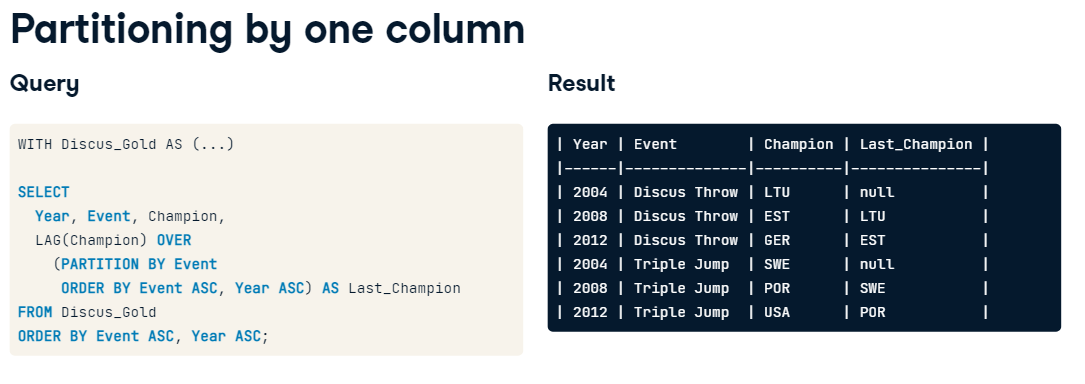

Let's look at a more complex partitioning.

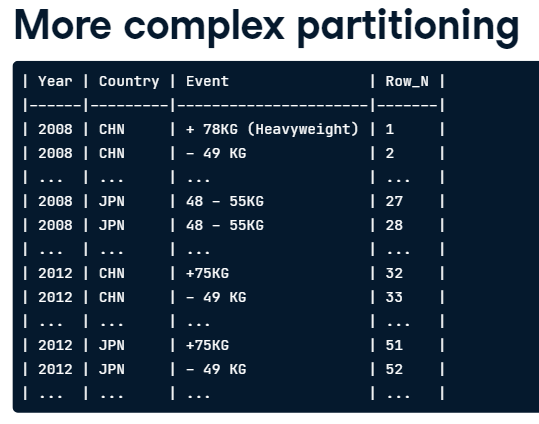

This result is a row numbering of Chinese and Japanese gold medals awarded to women. The row numbering extends across countries and events, and the goal is to reset it per country and year.

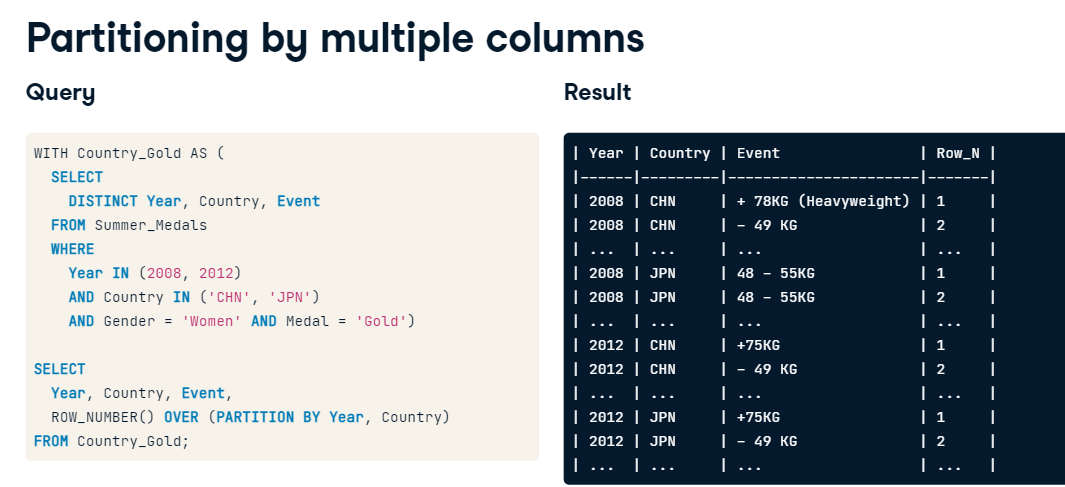

Partitioning by year and country in ROW_NUMBER will achieve this. Each combination of the unique values of Year and Country will be a partition. 2008 - China is one partition; 2008 - Japan is another, 2012 - China is yet another, and so on. As you can see in the result, the row number resets to 1 for each partition. You can partition by multiple columns if your groups are spread across columns.

- Return the previous champions of each year's event by gender.

```sql
WITH Tennis_Gold AS (
  SELECT DISTINCT
    Gender, Year, Country
  FROM Summer_Medals
  WHERE
    Year >= 2000 AND
    Event = 'Javelin Throw' AND
    Medal = 'Gold')

SELECT
  Gender, Year,
  Country AS Champion,
  -- Fetch the previous year's champion by gender
  LAG(Country) OVER (PARTITION BY Gender
                         ORDER BY Year ASC) AS Last_Champion
FROM Tennis_Gold
ORDER BY Gender ASC, Year ASC;
```

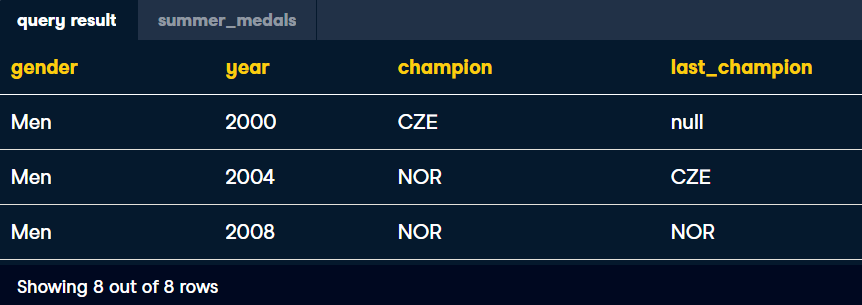

Partitioning correctly split the champions by gender, so that data on champions of one gender get mixed into the other gender's results.


##### Reigning champions by gender and event
In the previous exercise, you partitioned by gender to ensure that data about one gender doesn't get mixed into data about the other gender. If you have multiple columns, however, partitioning by only one of them will still mix the results of the other columns.


- Return the previous champions of each year's events by gender and event.

```sql
WITH Athletics_Gold AS (
  SELECT DISTINCT
    Gender, Year, Event, Country
  FROM Summer_Medals
  WHERE
    Year >= 2000 AND
    Discipline = 'Athletics' AND
    Event IN ('100M', '10000M') AND
    Medal = 'Gold')

SELECT
  Gender, Year, Event,
  Country AS Champion,
  -- Fetch the previous year's champion by gender and event
  LAG(Country) OVER (PARTITION BY Gender, Event
                         ORDER BY Year ASC) AS Last_Champion
FROM Athletics_Gold
ORDER BY Event ASC, Gender ASC, Year ASC;
```

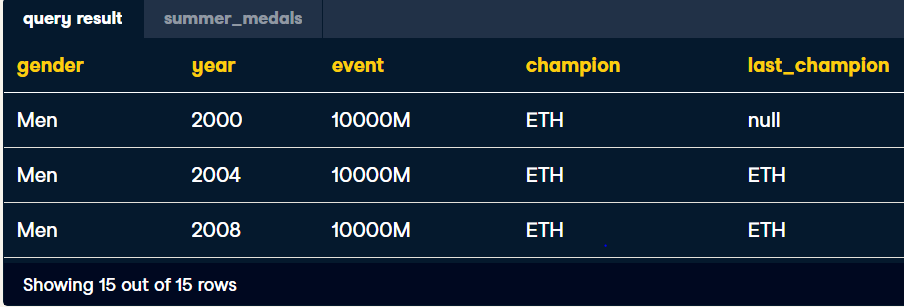
